In [2]:
# Import necessary libraries and configure matplotlib parameters
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import math
import time
import tqdm
import gc
import matplotlib as mpl
from scipy import stats
from numba import njit, prange
import seaborn as sns
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator
from brokenaxes import brokenaxes

mpl.rcdefaults()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2.8
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.xmargin'] = 0.05
plt.rcParams['axes.grid']='True'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['xtick.minor.visible'] ='True'
plt.rcParams['ytick.minor.visible'] ='True'
plt.rcParams['xtick.major.size'] =10
plt.rcParams['xtick.minor.size'] =5
plt.rcParams['xtick.major.width'] =2
plt.rcParams['xtick.minor.width'] =1
plt.rcParams['xtick.major.pad']=8
plt.rcParams['ytick.major.size'] =10
plt.rcParams['ytick.minor.size'] =5
plt.rcParams['ytick.major.width'] =2
plt.rcParams['ytick.minor.width'] =1
plt.rcParams['ytick.major.pad']=8
plt.rcParams['figure.subplot.wspace']=0.25
plt.rcParams['figure.subplot.hspace']=0.5
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['grid.linewidth'] = 2
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.8
plt.rcParams['savefig.bbox']='tight'
plt.rcParams['savefig.format']='pdf'
rc_dict = mpl.rcParams.copy()

In [4]:
# Read burst table
def Xreaddata(path, col_indices, new_col_names, startrow=0):
    if len(col_indices) != len(new_col_names):
        raise ValueError("The number of column indices must match the number of new column names.")
    df_0 = pd.read_csv(path, dtype=str)
    df = df_0.iloc[startrow:, col_indices]
    df.columns = new_col_names
    for col in df.columns:
        try:
            df[col] = df[col].astype(float)
        except ValueError:
            pass
    df = df.fillna(np.nan)
    df = df.sort_values(by='t')
    df = df.reset_index(drop=True)
    return df_0, df
    
b_fast1=Xreaddata('Data\\20201124A\\Burst_Table\\FAST#1.csv',
            [0,2,6,4],['t','s','w','f'],
            startrow=0)

b_fast2=Xreaddata('Data\\20201124A\\Burst_Table\\FAST#2.csv',
            [2,5,4,7],['t','s','w','f'],
            startrow=2) 
b_fast2[1]['s']=b_fast2[1]['s']/1000

b_ugmrt=Xreaddata('Data\\20201124A\\Burst_Table\\uGMRT.csv',
            [1,4,2,5],['t','s','w','f'],
            startrow=0)  

b_effelsberg=Xreaddata('Data\\20201124A\\Burst_Table\\Effelsberg.csv',
            [1,5,3,7],['t','s','w','f'],
            startrow=0)  

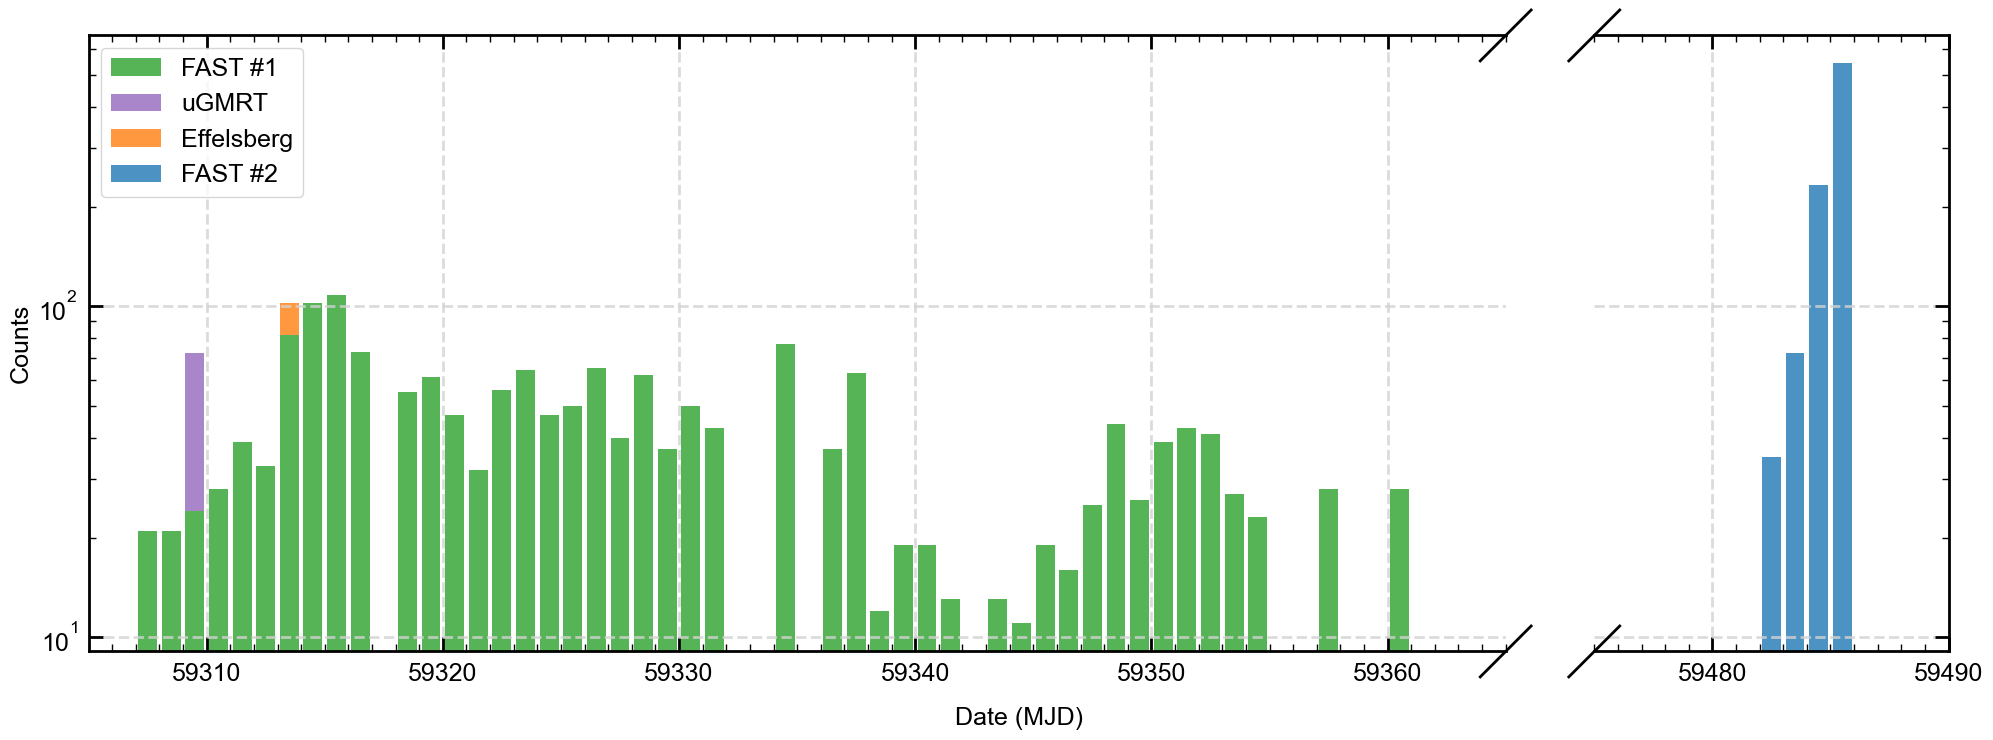

In [7]:
# Plot Figure 1
fig = plt.figure(figsize=(24,8))
bax = brokenaxes(xlims=((59305, 59365), (59475, 59490)), 
                 # ylims=(0,600),
                 wspace=0.1,despine=False,diag_color='k')
bax.hist(
    [b_fast1[1]['t'], b_ugmrt[1]['t'], b_effelsberg[1]['t']],
    bins = np.arange(np.floor(b_fast1[1]['t'].min()) - 1, np.ceil(b_fast1[1]['t'].max()) + 2, 1),
    # stacked=True, 
    label=[
        'FAST #1', 
        'uGMRT', 
        'Effelsberg', 
    ],
    color=['#2ca02c', '#9467bd', '#ff7f0e'],
    histtype='barstacked',
    rwidth=0.8,
    alpha=0.8
)
bax.hist(b_fast2[1]['t'],
         bins=np.arange(np.floor(b_fast2[1]['t'].min()) - 1, np.ceil(b_fast2[1]['t'].max()) + 2, 1),
         label='FAST #2',color='#1f77b4',rwidth=0.8, alpha=0.8 )
bax.set_xlabel('Date (MJD)', labelpad=40)
bax.set_ylabel('Counts', labelpad=40)
bax.set_yscale('log')
bax.legend(loc='upper left')
bax.axs[1].xaxis.set_ticks_position('both')
bax.axs[1].yaxis.set_ticks_position('right')
bax.axs[1].yaxis.set_tick_params(labelright=False)
bax.axs[0].xaxis.set_ticks_position('both')
bax.axs[0].yaxis.set_ticks_position('left')
for ax in bax.axs:
    ax.grid(True)  
for ax in bax.axs:
    ax.xaxis.set_minor_locator(MultipleLocator(1))


In [6]:
#Further reduce the data table
def Xselectdata2(df_s, nummin, dnum, sep):
    t_bins = np.arange(np.floor(df_s['t'].min()) - (1 - sep), np.ceil(df_s['t'].max()) + (1 - sep) + dnum, dnum)
    num, _ = np.histogram(df_s['t'], t_bins)
    date_s = np.where(num >= nummin)[0]
    date_s = date_s * dnum
    df_list = []
    for date in date_s:
        mask = np.logical_and(df_s['t'] > (date + np.floor(df_s['t'].min()) - (1 - sep)), 
                              df_s['t'] < (date + np.floor(df_s['t'].min()) - (1 - sep)) + dnum)
        df_temp = df_s.loc[mask, :].reset_index(drop=True)
        df_temp.columns = [f'{col}' for col in df_temp.columns] 
        df_list.append(df_temp)
    return df_s, df_list
    
def burstverify_anyday(bi,nummin,dnum,sep) :
    bi_ss=Xselectdata2(bi[1],nummin=nummin,dnum=dnum,sep=sep)
    b_s=[]
    for i in range(len(bi_ss[1])):
        b_s.append(bi_ss[1][i]['t']*86400)
        bi_ss[1][i]['t_s']=b_s[i]   
        waitingtime=np.diff(b_s[i])
        bi_ss[1][i]['waitingtime']=np.concatenate(([np.inf],waitingtime))
    return bi_ss

# Reduce FAST#1 data
b_ss=burstverify_anyday(b_fast1, nummin=1,dnum=1,sep=0)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

MJD 59310 period = 1.706017


 50%|██████████████████████████████████████████                                          | 1/2 [00:15<00:15, 15.96s/it]

MJD 59347 period = 1.707972


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:33<00:00, 16.92s/it]


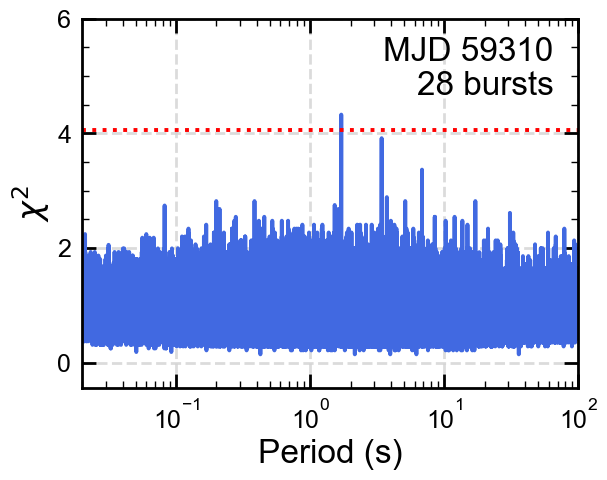

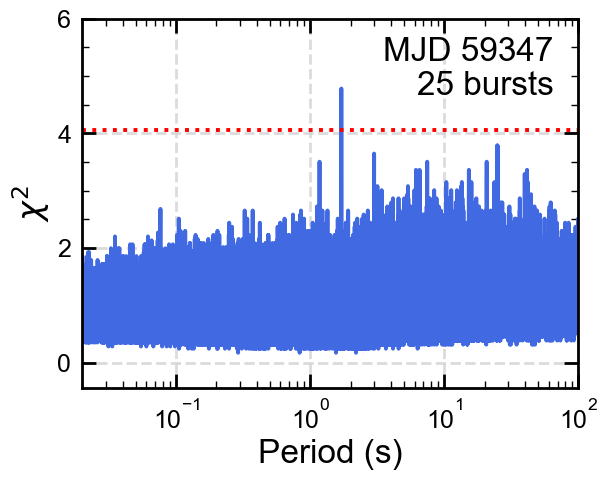

In [15]:
# Phase folding algorithm for periodicity analysis (numba)
@njit(parallel=True)
def phase_fold_and_calc_chi2(t, p_arr, bins_num=30):
    bursts_len= len(t)
    chi_arr = np.zeros(p_arr.shape[0], dtype=np.float64)
    q = 1.0 + (bins_num + 1) / (6.0 * bursts_len) # Williams' correction
    for i in prange(p_arr.shape[0]):
        p = p_arr[i]
        fold = np.mod(t / p, 1.0)
        O = np.zeros(bins_num, dtype=np.int64)
        for val in fold:
            if val < 1.0:
                bin_index = int(val * bins_num)
                if bin_index == bins_num:
                    bin_index = bins_num - 1
                O[bin_index] += 1
        E = len(t) / bins_num
        chi2 = np.sum((O - E)**2 / E) / (bins_num - 1)
        chi_arr[i] = chi2/q
    return chi_arr

# Segmented period search (when searching for periods > 0.1 s, exclude bursts with waiting times < 0.05 s)
def segmented_search(b_ss, day, bins_num):
    b_sss_0 = b_ss[1][day].loc[(b_ss[1][day]['waitingtime'] > 0)]
    p_arr_0 = np.linspace(0.01, 0.1, int((0.1-0.01)/1e-6)+1)
    chi2_arr_0 = phase_fold_and_calc_chi2(np.array(b_sss_0['t_s']), p_arr_0, bins_num)
    b_sss_1 = b_ss[1][day].loc[(b_ss[1][day]['waitingtime'] > 0.05)]
    p_arr_1 = np.linspace(0.1, 100, int((100-0.1)/1e-6)+1)
    chi2_arr_1 = phase_fold_and_calc_chi2(np.array(b_sss_1['t_s']), p_arr_1, bins_num)
    p_arr=np.concatenate((p_arr_0,p_arr_1))
    chi2_arr=np.concatenate((chi2_arr_0,chi2_arr_1))
    del p_arr_0, p_arr_1, chi2_arr_0, chi2_arr_1
    gc.collect()
    result = {
        'period_array': (p_arr),
        'chi2_array': (chi2_arr),
        'MJD': np.floor(min(b_sss_0['t'])),
        'N_burst':int(len(b_sss_0))
    }
    return result

gc.collect()
bins_num = 30
p_value = (1 - stats.norm.cdf(7))
threshold = stats.chi2.isf(p_value, bins_num-1)/(bins_num-1) 

# Plot periodograms (Figure 2)
for i in tqdm.tqdm([3,35]):
    gc.collect()
    r=segmented_search(b_ss, i, bins_num = 30)
    print(f'MJD {int(r['MJD'])} period = {r['period_array'][np.argmax(r['chi2_array'])]:.6f}')
    fig, ax=plt.subplots()
    ax.plot(r['period_array'], r['chi2_array'], alpha=1, color='royalblue')
    ax.set_xscale('log')
    ax.axhline(threshold, color='red', linestyle='dotted')
    ax.text(0.95, 0.95, 'MJD %i' % r['MJD'], transform=ax.transAxes, fontsize=24,
             verticalalignment='top', horizontalalignment='right')
    ax.text(0.95, 0.86, '%i bursts' % r['N_burst'], transform=ax.transAxes, fontsize=24,
             verticalalignment='top', horizontalalignment='right')
    ax.set_xlim(0.02, 100)
    ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.set_ylim(-0.45,6)
    ax.set_xlabel('Period (s)',fontsize=24)
    ax.set_ylabel('$\\chi ^{2}$',fontsize=24)
    del r,fig
    gc.collect()

pdot = 6.139630e-10


Text(0.5, 0, 'Phase')

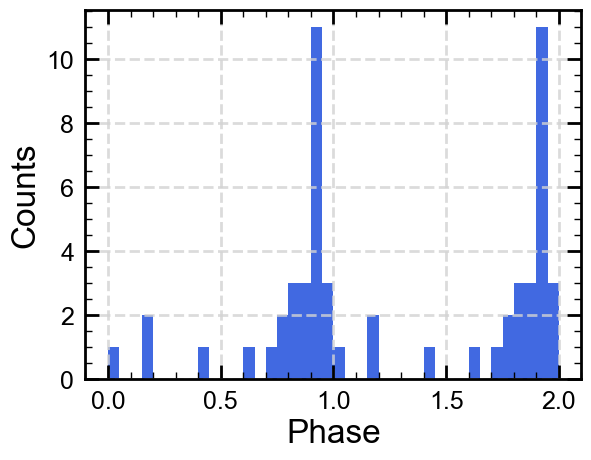

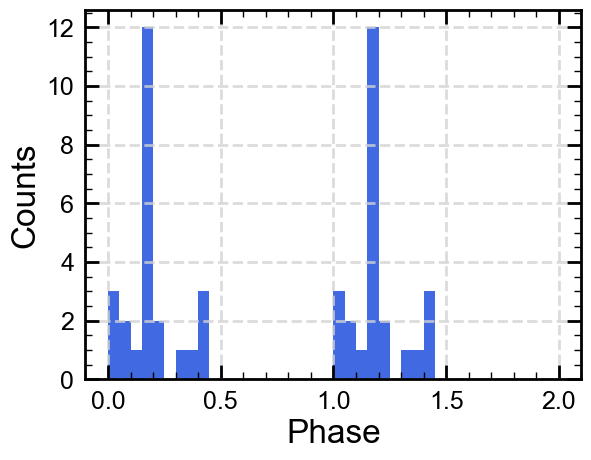

In [10]:
# Equation 7
def calculate_phase(t, period, pdot):
    phase = np.fmod((1 / pdot) * (np.log(period + pdot * t) - np.log(period)), 1.0)
    phase = np.where(phase < 0.0, phase + 1.0, phase)
    return phase

p_0 = 1.706017 # MJD 59310 period 
t_0 = np.mean(b_ss[1][3]['t_s']) # MJD 59310 mean TOA
p_1 = 1.707972 # MJD 59347 period
t_1 = np.mean(b_ss[1][35]['t_s']) # MJD 59347 mean TOA
pdot = (p_1-p_0)/(t_1-t_0)
print(f'pdot = {pdot:.6e}')

# Plot folded phase histograms (Figure 2)
phases_59310=calculate_phase(b_ss[1][3]['t_s']-t_0, p_0, pdot)
fig=plt.figure()
plt.hist(phases_59310, np.linspace(0,1,21),alpha=1,color='royalblue')
plt.hist(phases_59310+1, np.linspace(1,2,21),alpha=1,color='royalblue')
plt.ylabel('Counts',fontsize=24)
plt.xlabel('Phase',fontsize=24)

phases_59347=calculate_phase(b_ss[1][35]['t_s']-t_0, p_0, pdot)
fig=plt.figure()
plt.hist(phases_59347, np.linspace(0,1,21),alpha=1,color='royalblue')
plt.hist(phases_59347+1, np.linspace(1,2,21),alpha=1,color='royalblue')
plt.ylabel('Counts',fontsize=24)
plt.xlabel('Phase',fontsize=24)

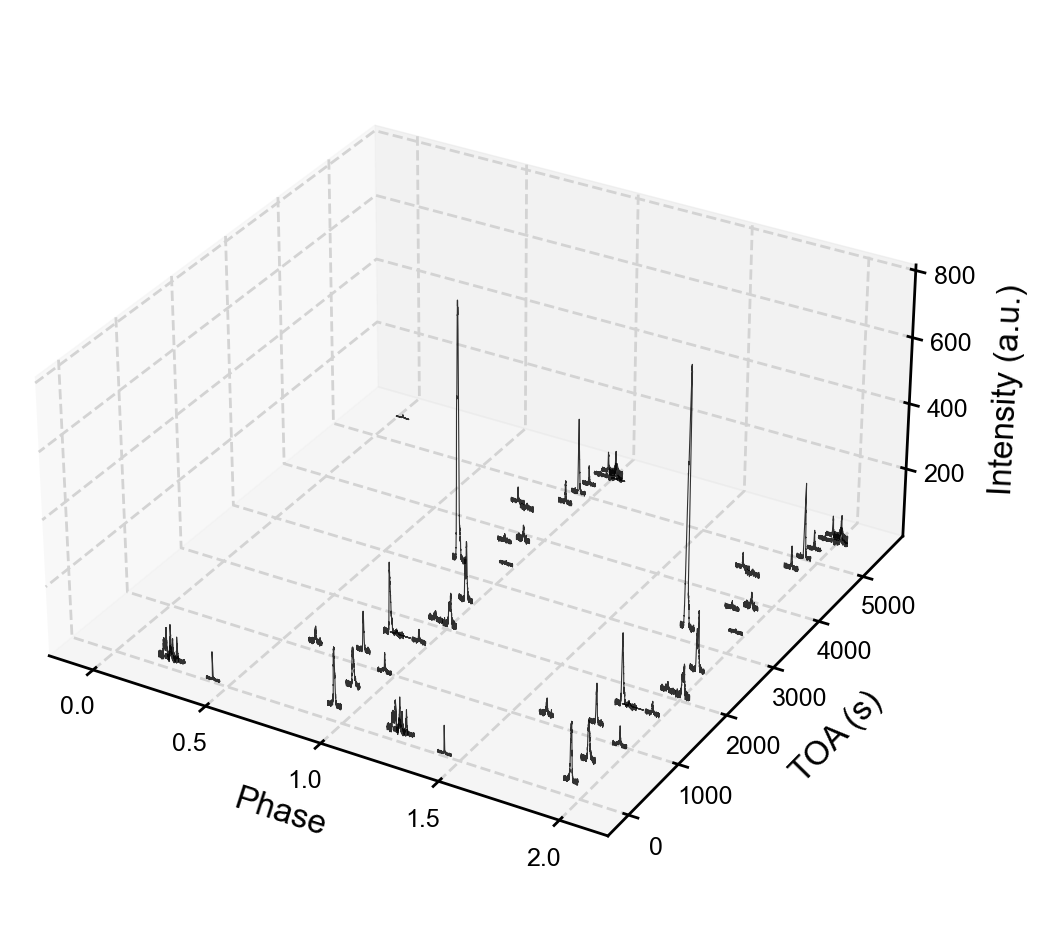

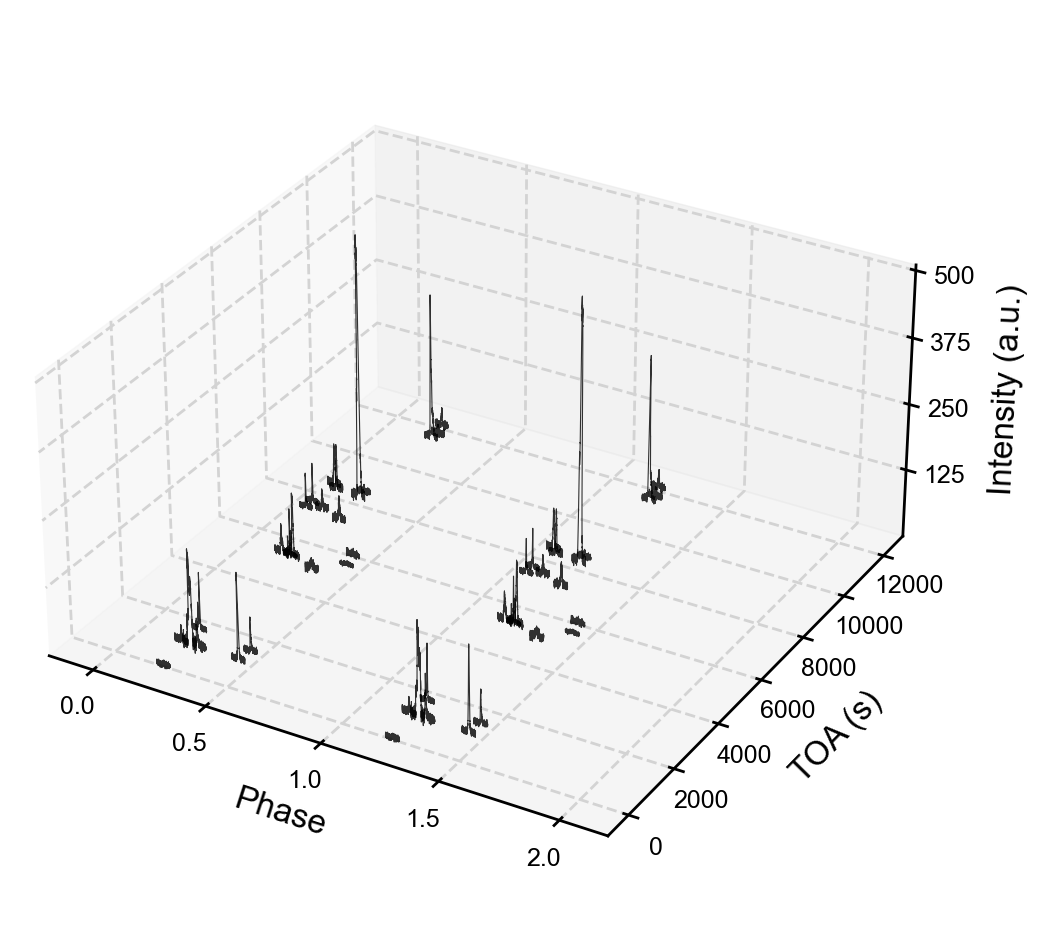

In [12]:
# Plot Figure 3
DATA_np = np.load('Data\\20201124A\\FAST#1_1863_Bursts\\DATA_list.npy', allow_pickle=True)
SNR_np = np.load('Data\\20201124A\\FAST#1_1863_Bursts\\SNR_list.npy', allow_pickle=True)
MJD_np = np.load('Data\\20201124A\\FAST#1_1863_Bursts\\MJD_list.npy', allow_pickle=True)
Nbin_np = np.load('Data\\20201124A\\FAST#1_1863_Bursts\\Nbin_list.npy', allow_pickle=True)

def Xselectdatas(mjd_np, x_np, nummin, dnum, sep):
    t_bins = np.arange(np.floor(MJD_np.min()) - (1 - sep), np.ceil(MJD_np.max()) + (1 - sep) + dnum, dnum)
    num, _ = np.histogram(MJD_np, t_bins)
    date_s = np.where((num >= nummin))[0]
    date_s = date_s * dnum
    df_list = []
    for date in date_s:
        mask = np.logical_and(MJD_np > (date + np.floor(MJD_np.min()) - (1 - sep)), 
                              MJD_np < (date + np.floor(MJD_np.min()) - (1 - sep)) + dnum)
        df_temp = x_np[mask]
        df_list.append(df_temp)
    return  df_list

DATA_ss=Xselectdatas(MJD_np, DATA_np, nummin=10, dnum=1, sep=0)
SNR_ss=Xselectdatas(MJD_np, SNR_np, nummin=10, dnum=1, sep=0)
NBIN_ss=Xselectdatas(MJD_np, Nbin_np, nummin=10, dnum=1, sep=0)
MJD_ss=Xselectdatas(MJD_np, MJD_np, nummin=10, dnum=1, sep=0)

day=3 # MJD 59310

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(MJD_ss[day])):
    t=(MJD_ss[day][i]) * 86400-t_0
    Y_i = (MJD_ss[day][i]-MJD_ss[day][0]) * 86400
    Z_i = (DATA_ss[day][i]/max(DATA_ss[day][i]))*SNR_ss[day][i]
    P_i= calculate_phase(t,p_0,pdot)
    X_i = np.linspace(P_i, P_i + (NBIN_ss[day][i]) * (0.000196608 / (p_0+pdot*(t))), NBIN_ss[day][i].astype(np.int64))
    ax.plot(X_i, np.full_like(X_i, Y_i), Z_i, color='k', linewidth=0.8,alpha=0.8)
    ax.plot(X_i+1, np.full_like(X_i, Y_i), Z_i, color='k', linewidth=0.8,alpha=0.8)
ax.tick_params(axis='x', direction='in')
ax.tick_params(axis='y', direction='in')
ax.tick_params(axis='z', direction='in')
ax.set_xlim(-0.15, 2.15)
ax.set_zticks([200,400,600,800])
ax.set_zlim(7, 800)
ax.set_xlabel('Phase',fontsize=24, labelpad=20)
ax.set_ylabel('TOA (s)',fontsize=24, labelpad=25)
ax.set_zlabel('Intensity (a.u.)',fontsize=24, labelpad=20)
ax.text2D(1.1, 0.5, '            ', transform=ax.transAxes,
         va='center',
         ha='center', 
         rotation='vertical')
ax.set_box_aspect([2, 2, 1]) 
ax.xaxis.set_minor_locator(NullLocator())
ax.yaxis.set_minor_locator(NullLocator())
ax.zaxis.set_minor_locator(NullLocator())

day=35 # MJD 59347

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(MJD_ss[day])):
    t=(MJD_ss[day][i]) * 86400-t_0
    Y_i = (MJD_ss[day][i]-MJD_ss[day][0]) * 86400
    Z_i = (DATA_ss[day][i]/max(DATA_ss[day][i]))*SNR_ss[day][i]
    P_i= calculate_phase(t,p_0,pdot)
    X_i = np.linspace(P_i, P_i + (NBIN_ss[day][i]) * (0.000196608 / (p_0+pdot*(t))), NBIN_ss[day][i].astype(np.int64))
    ax.plot(X_i, np.full_like(X_i, Y_i), Z_i, color='k', linewidth=0.8,alpha=0.8)
    ax.plot(X_i+1, np.full_like(X_i, Y_i), Z_i, color='k', linewidth=0.8,alpha=0.8)
ax.tick_params(axis='x', direction='in')
ax.tick_params(axis='y', direction='in')
ax.tick_params(axis='z', direction='in')
ax.set_xlim(-0.15, 2.15)
ax.set_zticks([125,250,375,500])
ax.set_zlim(7, 500)
ax.set_xlabel('Phase',fontsize=24, labelpad=20)
ax.set_ylabel('TOA (s)',fontsize=24, labelpad=25)
ax.set_zlabel('Intensity (a.u.)',fontsize=24, labelpad=20)
ax.text2D(1.1, 0.5, '            ', transform=ax.transAxes,
         va='center', 
         ha='center', 
         rotation='vertical')
ax.set_box_aspect([2, 2, 1]) 
ax.xaxis.set_minor_locator(NullLocator())
ax.yaxis.set_minor_locator(NullLocator())
ax.zaxis.set_minor_locator(NullLocator())

Text(0, 0.5, '$\\dot P$ (s s$^{-1}$)')

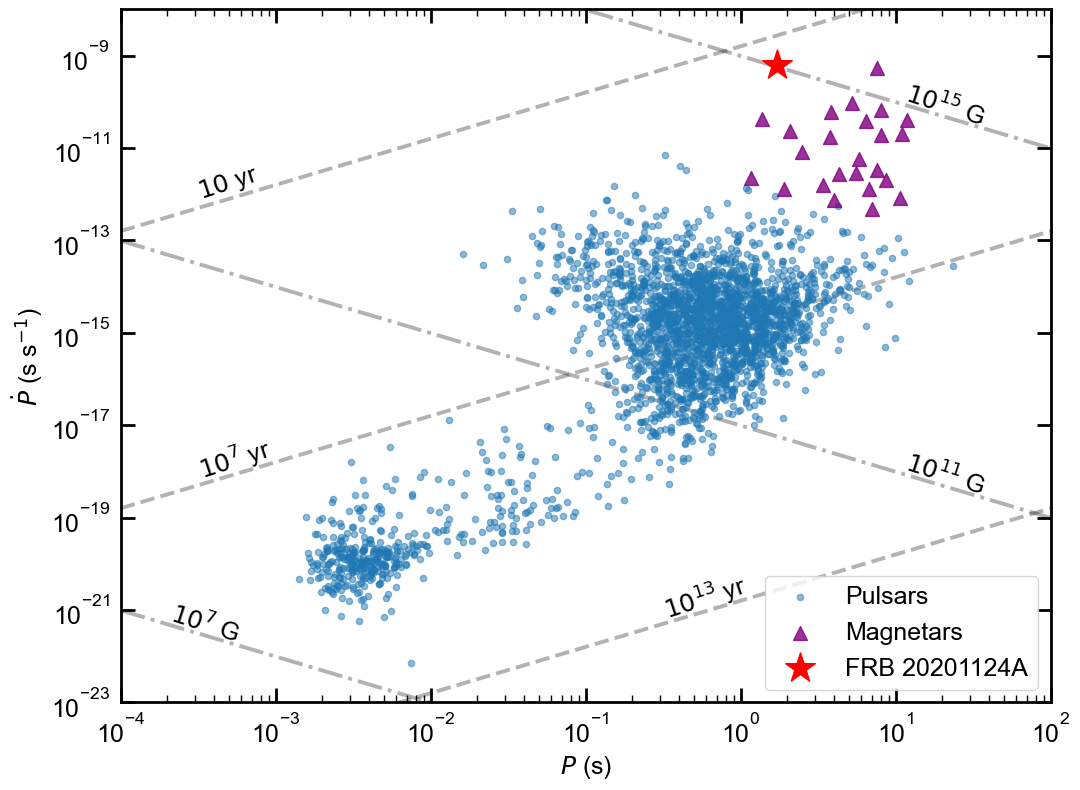

In [16]:
# Plot Figure 4
def Xreadpulsar(path, col_indices, new_col_names, startrow=0):
    if len(col_indices) != len(new_col_names):
        raise ValueError("The number of column indices must match the number of new column names.")
    df_0 = pd.read_csv(path)
    df = df_0.iloc[startrow:, col_indices]
    df.columns = new_col_names
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.fillna(np.nan)
    df = df.reset_index(drop=True)
    return df_0, df

pulsars = Xreadpulsar('Data\\pulsar.csv',
                      [1, 3, 6], ['name', 'p0', 'p1'],
                      startrow=3)
fig, ax=plt.subplots(1,1,figsize=(12,9))
plt.scatter(pulsars[1]['p0'].loc[3.2e19*(pulsars[1]['p0']*pulsars[1]['p1'])**0.5<0.5e14],
            pulsars[1]['p1'].loc[3.2e19*(pulsars[1]['p0']*pulsars[1]['p1'])**0.5<0.5e14],
            marker='o',s=20,alpha=0.5,label='Pulsars')
plt.scatter(pulsars[1]['p0'].loc[3.2e19*(pulsars[1]['p0']*pulsars[1]['p1'])**0.5>=0.5e14],
            pulsars[1]['p1'].loc[3.2e19*(pulsars[1]['p0']*pulsars[1]['p1'])**0.5>=0.5e14],
            color='purple',marker='^',s=100,alpha=0.8,label='Magnetars')
plt.scatter(1.707,6.14e-10,marker='*',s=500,color='red',label='FRB 20201124A')
plt.xscale('log')
plt.yscale('log')
plt.text(11,0.3e-10,'$10^{15}$ G',rotation=-18)
plt.text(11,3e-19,'$10^{11}$ G',rotation=-18)
plt.text(2E-4,0.2e-21,'$10^{7}$ G',rotation=-18)
plt.text(3e-4,0.08e-11,'$10$ yr',rotation=18)
plt.text(3e-4,0.07e-17,'$10^7$ yr',rotation=18)
plt.text(0.3,0.65e-21,'$10^{13}$ yr',rotation=18)
plt.legend(loc='lower right')
plt.xlim(1e-4,100)
plt.ylim(1e-23,1e-8)
xlim=ax.get_xlim()
ylim=ax.get_ylim()
plt.grid()
p0=np.linspace(xlim[0],xlim[1],100)
for logb in (7,11,15) :
    plt.plot((p0),((10**(logb)/3.2e19)**2)/p0,'-.',alpha=0.3,c='k',zorder=-1)
for logt in (1,7,13) :
    plt.plot((p0),p0/(2*(10**(logt)*86400*365)),'--',alpha=0.3,c='k',zorder=-1)
ax.autoscale(enable=False)
plt.xlabel('$P$ (s)')
plt.ylabel('$\\dot P$ (s s$^{-1}$)')

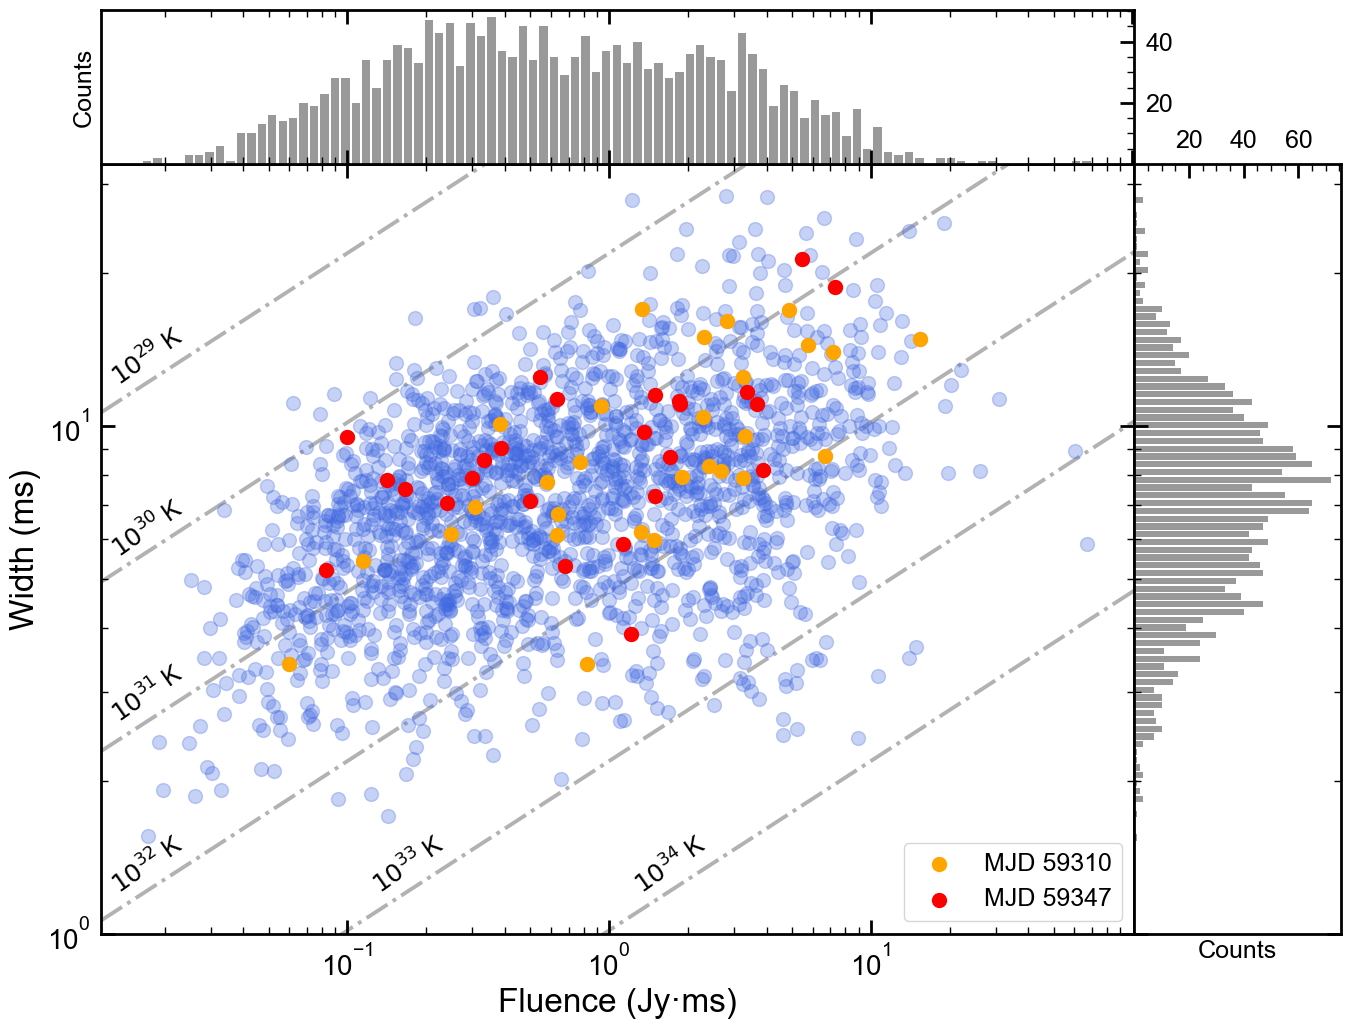

In [18]:
# Plot Figure 5
b_ss=burstverify_anyday(b_fast1, nummin=1,dnum=1,sep=0)
fig = plt.figure(figsize=(16, 12))
ax = plt.subplot() 
ax.scatter(b_fast1[1]['f'], b_fast1[1]['w'], marker='o',c='royalblue', alpha=0.3, s=100)
ax.scatter(b_ss[1][3]['f'], b_ss[1][3]['w'], marker='o',c='orange', label='MJD 59310',alpha=1, s=100)
ax.scatter(b_ss[1][35]['f'], b_ss[1][35]['w'], marker='o',c='red', label='MJD 59347',alpha=1, s=100)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=18,loc='lower right')
ax.tick_params(axis='both', labelsize=20)
ax.set_xticks([0.1,1,10])
ax.set_yticks([1,10])
ax.set_xlabel('Fluence (Jy·ms)',fontsize=24)
ax.set_ylabel('Width (ms)',fontsize=24)
plt.grid()
xlim=ax.get_xlim()
ylim=ax.get_ylim()
ax_joint = ax
x=np.linspace(xlim[0],xlim[1],100)
m=np.arange(29,35,1.0)
for i in m :
    ax.plot((x),(x*1.25**(-2)*0.3861**2*1.1*10**(35-i))**(1/3),'-.',alpha=0.3,c='k',zorder=-1)
    ax.autoscale(enable=False)
ax.autoscale(enable=False)
ax.text(0.12, 1.2, '$10^{33}$ K'
        , fontsize=18, rotation=35)
ax.text(1.2,1.2, '$10^{34}$ K'
        , fontsize=18, rotation=35)
ax.text(0.012, 1.2, '$10^{32}$ K'
        , fontsize=18, rotation=35)
ax.text(0.012, 2.6, '$10^{31}$ K'
        , fontsize=18, rotation=35)
ax.text(0.012, 5.5, '$10^{30}$ K'
        , fontsize=18, rotation=35)
ax.text(0.012, 12, '$10^{29}$ K'
        , fontsize=18, rotation=35)

divider = make_axes_locatable(ax)
ax_f = divider.append_axes('top', size='20%', pad=0)
plt.grid()
ax_w = divider.append_axes('right', size='20%', pad=0)
plt.grid()

f_counts, f_bins = np.histogram(b_fast1[1]['f'], bins=np.logspace(np.log10(xlim[0]), np.log10(xlim[1]), 100))
ax_f.bar(f_bins[:-1], f_counts, width=np.diff(f_bins)*0.8, align='edge', color='grey', alpha=0.8,label='FRB 20201124A_FAST')
ax_f.set_xscale('log')
ax_f.set_xlim(xlim)
ax_f.set_xticklabels([])
ax_f.set_yticks([20,40])
ax_f.set_ylabel('Counts', fontsize=18)
ax_f.yaxis.set_ticks_position('right')
ax_f.yaxis.set_label_position('left')
ax_f.tick_params(axis='both', which='both', direction='in', labelsize=18)

w_counts, w_bins = np.histogram(b_fast1[1]['w'], bins=np.logspace(np.log10(ylim[0]), np.log10(ylim[1]), 100))
ax_w.barh(w_bins[:-1], w_counts, height=np.diff(w_bins)*0.8, align='edge', color='grey', alpha=0.8,label='FRB 20201124A_FAST')
ax_w.set_yscale('log')
ax_w.set_ylim(ylim)
ax_w.set_yticklabels([])
ax_w.set_xticks([20,40,60])
ax_w.set_xlabel('Counts', fontsize=18)
ax_w.xaxis.set_ticks_position('top')
ax_w.xaxis.set_label_position('bottom')
ax_w.tick_params(axis='both', which='both', direction='in', labelsize=18)